In [1]:
import numpy as np

fs = 44100
ir = np.load('files/KEMAR-hrir.npy')

In [2]:
ir.shape

(256, 2, 710)

IndexError: index 1000 is out of bounds for axis 2 with size 710

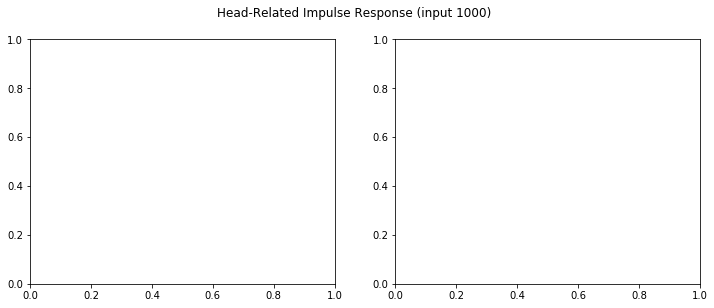

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 4.5)

input_idx = 100

t = np.arange(ir.shape[0])/fs

fig, axes = plt.subplots(1, 2)
fig.suptitle(f'Head-Related Impulse Response (input {input_idx})')
for i, ax in enumerate(axes): 
    ax.plot(t, ir[:, i, input_idx], color='k')
    ax.set(xlabel=r'Time (s)', ylabel='Amplitude', title=f'{"left" if i == 0 else "right"} ear', xlim=(t[0], t[-1]), ylim=(-0.75, 0.75))

In [ ]:
from pymor.operators.numpy import NumpyHankelOperator

H = NumpyHankelOperator(ir)

In [ ]:
print(H)

In [ ]:
from pymor.reductors.era import ERAReductor

era = ERAReductor(ir, sampling_time=1/fs)

In [ ]:
from pymor.tools.formatsrc import print_source

print_source(ERAReductor.reduce)

In [ ]:
from pymor.tools.timing import Timer

roms = dict()
with Timer('Initial computation (r=80)'):
    roms['80'] = era.reduce(80)

In [ ]:
print(roms['80'])

In [ ]:
with Timer('Recomputation (r=80)'):
    roms['80'] = era.reduce(80)

In [ ]:
with Timer('Recomputation (r=100)'):
    roms['100'] = era.reduce(100)

In [ ]:
with Timer('Recomputation (r=120)'):
    roms['120'] = era.reduce(120)

In [ ]:
from pymor.algorithms.to_matrix import to_matrix
from pymor.operators.numpy import NumpyMatrixOperator

# slice the model for plotting
sliced_roms = dict()
for key, rom in roms.items():
    sliced_roms[key] = rom.with_(B=NumpyMatrixOperator(to_matrix(rom.B)[:, input_idx].reshape(-1, 1)),
                                 D=NumpyMatrixOperator(to_matrix(rom.D)[:, input_idx].reshape(-1, 1)))

In [ ]:
flim = np.array((20, fs/2))
wlim = 2 * np.pi * flim / fs

fig, ax = plt.subplots(2, 2, figsize=(12, 9))
ax = ax.T.ravel()
ax[0].semilogx(np.fft.rfftfreq(256, 1/fs), 20*np.log10(np.abs(np.fft.rfft(ir[:, 0, input_idx]))), color='k', label='data')
ax[2].semilogx(np.fft.rfftfreq(256, 1/fs), 20*np.log10(np.abs(np.fft.rfft(ir[:, 1, input_idx]))), color='k', label='data')
for order, rom in sliced_roms.items():
    rom.transfer_function.bode_plot(wlim, ax=ax, dB=True, Hz=True, label=f'r = {order}')
ax[0].set(xlabel='Frequency (Hz)', title='left ear', xlim=flim, ylim=(-24, 12))
ax[0].legend()
ax[0].grid()
fig.delaxes(ax[1])
ax[2].set(xlabel='Frequency (Hz)', title='right ear', xlim=flim, ylim=(-24, 12))
ax[2].legend()
ax[2].grid()
fig.delaxes(ax[3])

In [ ]:
from pymor.algorithms.timestepping import DiscreteTimeStepper

fig, axes = plt.subplots(1, 2)
fig.suptitle(f'Error Impulse Response (input {input_idx})')
for rom in sliced_roms.values():
    rom = rom.with_(T=256, time_stepper=DiscreteTimeStepper())
    hrir = rom.impulse_resp()[1:, :, 0] / fs
    error = ir[..., input_idx] - hrir
    for i, ax in enumerate(axes): 
        ax.plot(t, error[:, i])
        ax.set(xlabel=r'Time (s)', ylabel='Amplitude', title=f'{"left" if i == 0 else "right"} ear', ylim=(-0.075, 0.075))
        ax.legend(('r = 80', 'r = 100', 'r = 120'))